In [1]:
from pyMez import *

Importing pyMez, this should take roughly 30 seconds
Importing Code.DataHandlers.GeneralModels
It took 1.974 s to import Code.DataHandlers.GeneralModels
Importing Code.DataHandlers.HTMLModels
It took 0.328 s to import Code.DataHandlers.HTMLModels
Importing Code.DataHandlers.NISTModels
It took 3.844 s to import Code.DataHandlers.NISTModels
Importing Code.DataHandlers.TouchstoneModels
It took 0.004 s to import Code.DataHandlers.TouchstoneModels
Importing Code.DataHandlers.XMLModels
It took 0.12 s to import Code.DataHandlers.XMLModels
Importing Code.DataHandlers.ZipModels
It took 0.01 s to import Code.DataHandlers.ZipModels
Importing Code.InstrumentControl.Experiments
It took 0.624 s to import Code.InstrumentControl.Experiments
Importing Code.InstrumentControl.Instruments
It took 0.007 s to import Code.InstrumentControl.Instruments
Importing Code.Utils.Names
It took 0.005 s to import Code.Utils.Names
It took 6.916 s to import all of the active modules


In [111]:
class W2P(AsciiDataTable):
    """W2p is a class for holding 2 port wave parameters. The wave parameters are in the format used
    by the uncertainty framework, [Frequency,reA1_D1,imA1_D1,reB1_D1..imB2_D2]"""
    def __init__(self,file_path=None,**options):
        """Intializes the TwelveTermErrorModel """
        defaults= {"data_delimiter": "\t", "column_names_delimiter": ",", "specific_descriptor": None,
                   "general_descriptor": 'Wave_Parameters', "extension": 'w2p', "comment_begin": "!", "comment_end": "\n",
                   "header": None,
                   "column_names":make_wave_parameter_column_names(),
                   "column_names_begin_token":"!","column_names_end_token": "\n", "data": None,
                   "row_formatter_string": None, "data_table_element_separator": None,"row_begin_token":None,
                   "row_end_token":None,"escape_character":None,
                   "data_begin_token":None,"data_end_token":None,
                   "column_types":['float' for i in range(len(make_wave_parameter_column_names()))],
                   "column_units":["GHz"]+[None for i in range(len(make_wave_parameter_column_names())-1)]
                   }
        self.options={}
        for key,value in defaults.iteritems():
            self.options[key]=value
        for key,value in options.iteritems():
            self.options[key]=value
        try:
            AsciiDataTable.__init__(self,file_path,**self.options)
            
        except:
            print("Moving to parsing unknown schema")
            self.__read_and_fix__()
            self.options["data"]=self.data
            self.options["comments"]=self.comments
            AsciiDataTable.__init__(self,**self.options)
            if file_path:
                self.path=file_path

            print("{0} sucessfully parsed".format(self.path))
        self.update_complex_data()

    def update_complex_data(self):
        """Uses self.data to update the complex_data attribute. """
        if self.data:
            self.complex_data=[]
            self.complex_column_names=["Frequency"]+map(lambda x:x.replace("re",""),
                                                        self.column_names[1::2])
            for row in self.data[:]:
                row=map(lambda x:float(x),row)
                frequency=row[0]
                real_data=row[1::2]
                imaginary_data=row[2::2]
                new_row=[frequency]+[complex(real,imaginary_data[index]) for index,real in enumerate(real_data) ]
                self.complex_data.append(new_row)
                
    def get_amplitude(self,parameter_name=None,column_index=None):
        """Returns a list of amplitudes of the complex wave parameter specified by parameter_name,
        or column_index"""
        if not column_index:
            column_index=self.complex_column_names.index(parameter_name)
        amplitudes=map(lambda x:abs(x[column_index]),self.complex_data[:])
        return amplitudes
    
    def get_phase(self,parameter_name=None,column_index=None):
        """Returns a list of amplitudes of the complex wave parameter specified by parameter_name,
        or column_index"""
        if not column_index:
            column_index=self.complex_column_names.index(parameter_name)
        amplitudes=map(lambda x:180./np.pi*cmath.phase(x[column_index]),self.complex_data[:])
        return amplitudes
    
    def __read_and_fix__(self):
        """Reads a w2p file and fixes any problems with delimiters. Since w2p files may use
        any white space or combination of white space as data delimiters it reads the data and creates
        a uniform delimter. This means a file saved with save() will not be the same as the original if the
        whitespace is not uniform. It will also remove blank lines. """
        
        in_file=open(self.path,'r')
        # to keep the logic clean we will repeatedly cycle through self.lines
        # but in theory we could do it all on the line input stage
        self.lines=[]
        for line in in_file:
            self.lines.append(line)
        # now we need to collect and extract all the inline comments
        # There should be two types ones that have char position EOL, -1 or 0
        self.comments=collect_inline_comments(self.lines,begin_token="!",end_token="\n")
        # change all of them to be 0 or -1
        if self.comments is None:
            pass
        else:
            for index,comment in enumerate(self.comments):
                if comment[2]>1:
                    self.comments[index][2]=-1
                else:
                    self.comments[index][2]=0

        # now use our w2p column names 
        self.column_names=make_wave_parameter_column_names()
        #print("{0} are {1}".format("self.column_names",self.column_names))

        # remove the comments
        stripped_lines=strip_inline_comments(self.lines,begin_token="!",end_token="\n")
        #print stripped_lines
        self.data=[]
        self.options["data_begin_line"]=self.options["data_end_line"]=0
        data_lines=[]
        self.row_pattern=make_row_match_string(self.column_names)
        #print("{0} is {1}".format("self.row_pattern",self.row_pattern))
        for index,line in enumerate(stripped_lines):
            if re.search(self.row_pattern,line):
                data_lines.append(index)
                #print re.search(self.row_pattern,line).groupdict()
                row_data=re.search(self.row_pattern,line).groupdict()
                self.add_row(row_data=row_data)


        if data_lines != []:
            self.options["data_begin_line"]=min(data_lines)+len(self.comments)
            self.options["data_end_line"]=max(data_lines)+len(self.comments)


    
    def show(self, **options):
        """Plots any table with frequency as its x-axis and column_names as the x-axis in a
        series of subplots"""
        defaults = {"display_legend": False,
                    "save_plot": False,
                    "directory": None,
                    "specific_descriptor": "WaveParameter",
                    "general_descriptor": "Plot",
                    "file_name": None,
                    "plots_per_column": 2,
                    "plot_format": 'b-',
                    "share_x": False,
                    "subplots_title": True,
                    "plot_title": None,
                    "plot_size": (12, 24),
                    "dpi": 80,
                    "format": "MA",
                    "x_label": True,
                    "grid": True}
        plot_options = {}
        for key, value in defaults.iteritems():
            plot_options[key] = value
        for key, value in options.iteritems():
            plot_options[key] = value


        x_data = np.array(self["Frequency"])
        y_data_columns = self.column_names[:]
        y_data_columns.remove("Frequency")
        number_plots = len(y_data_columns)
        number_columns = plot_options["plots_per_column"]
        number_rows = int(round(float(number_plots) / float(number_columns)))
        figure, axes = plt.subplots(ncols=number_columns, nrows=number_rows, sharex=plot_options["share_x"],
                                    figsize=plot_options["plot_size"], dpi=plot_options["dpi"])
        for plot_index, ax in enumerate(axes.flat):
            if plot_index < number_plots:
                y_data = np.array(self[y_data_columns[plot_index]])
                ax.plot(x_data, y_data, plot_options["plot_format"], label=y_data_columns[plot_index])
                if plot_options["display_legend"]:
                    ax.legend()
                if plot_options["subplots_title"]:
                    ax.set_title(y_data_columns[plot_index])
                if plot_options["x_label"]:
                    ax.set_xlabel("Frequency ")
                if plot_options["grid"]:
                    ax.grid()
            else:
                pass

        if plot_options["plot_title"]:
            plt.suptitle(plot_options["plot_title"])
        plt.tight_layout()
        # Dealing with the save option
        if plot_options["file_name"] is None:
            file_name = auto_name(specific_descriptor=plot_options["specific_descriptor"],
                                  general_descriptor=plot_options["general_descriptor"],
                                  directory=plot_options["directory"], extension='png', padding=3)
        else:
            file_name = plot_options["file_name"]
        if plot_options["save_plot"]:
            # print file_name
            plt.savefig(os.path.join(plot_options["directory"], file_name))
        else:
            plt.show()
        return figure



   
    





In [95]:
schema=read_schema(r"C:\Share\WR15_Kits_VDI_20180223\WR15_Kit_Short_P1_WR15_Wave_Parameters_20180223_001.schema")

In [96]:
w2p=W2P(r"C:\Share\WR15_Kits_VDI_20180223\Short_10072_P1_Keysight_Short_P2_WR15_Wave_Parameters_20180223_001.w2p",**schema)

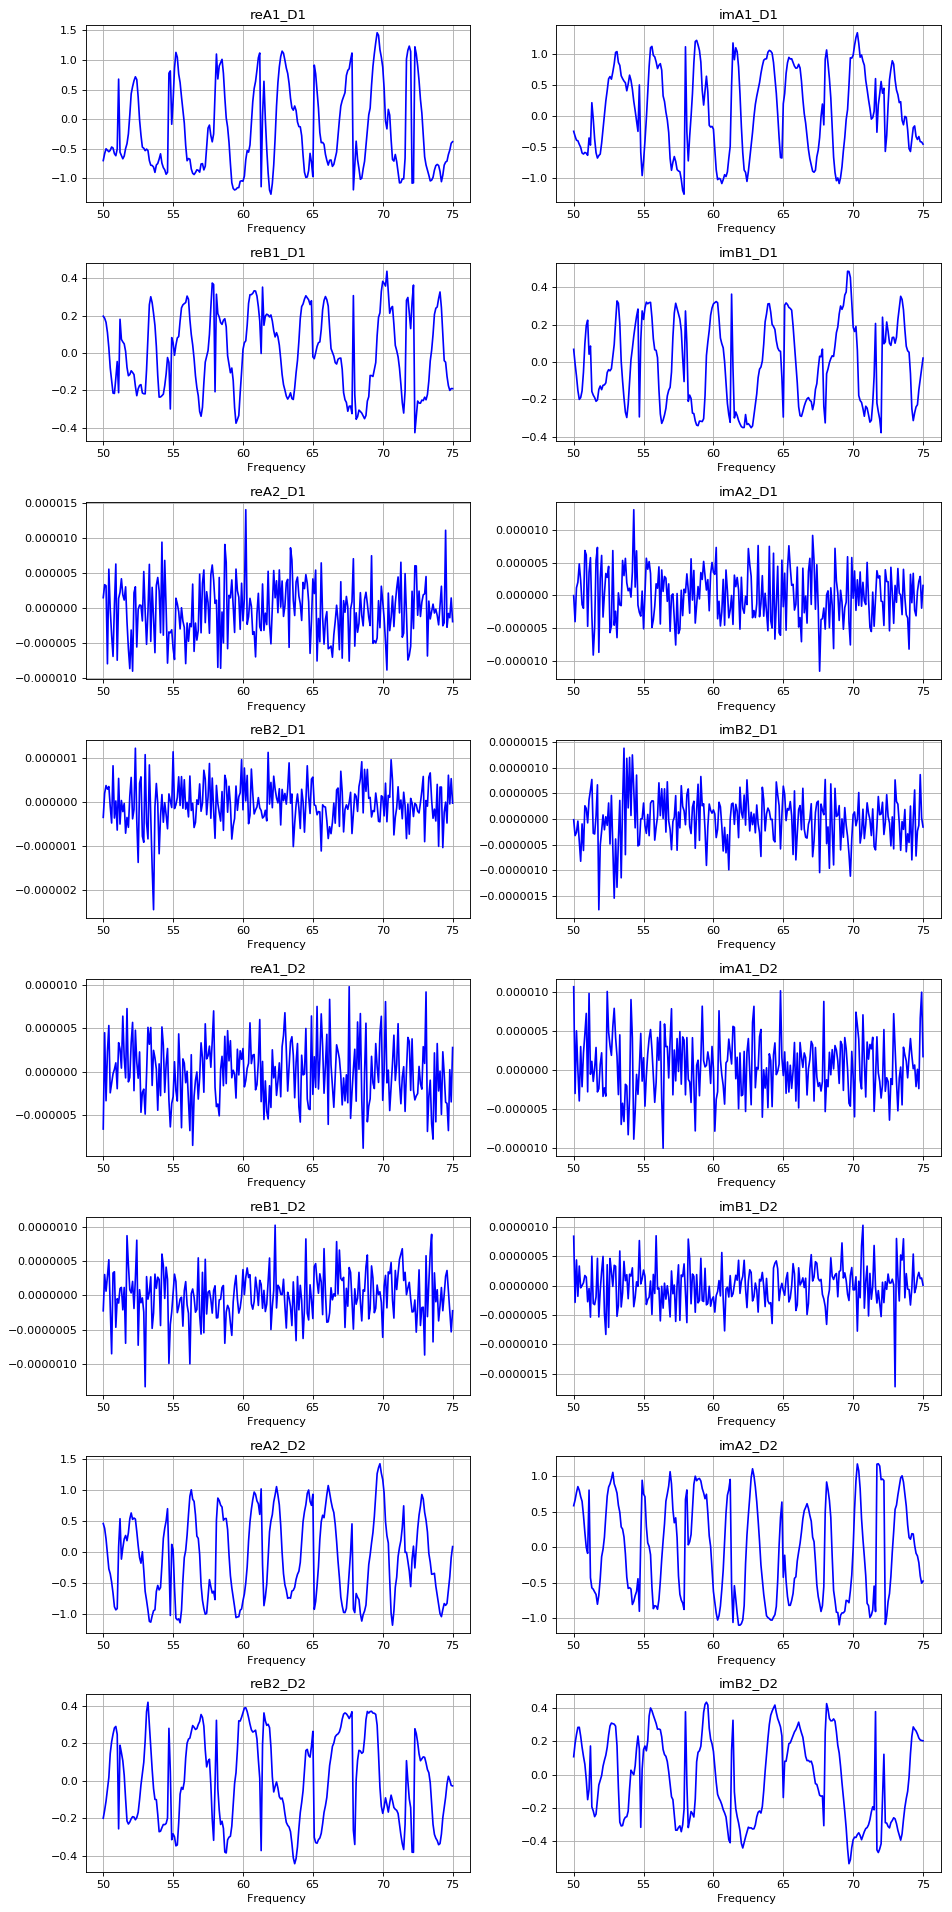

In [97]:
w2p.show();

In [98]:
w2p.get_amplitude("A1_D1")

[0.7439285937723481,
 0.6696833191877269,
 0.6366655952987913,
 0.6611056518169071,
 0.7172603223038424,
 0.7319966938526432,
 0.7619136634247656,
 0.7862156318032173,
 0.8303452084522535,
 0.862690225590534,
 0.8119495992448568,
 0.7633716236142677,
 0.7316429413687117,
 0.6535119667092125,
 0.6722646835539504,
 0.7270136481788765,
 0.7758994711437373,
 0.796791265610049,
 0.6875272621716153,
 0.6197237623175162,
 0.6148300281628609,
 0.5919123326823146,
 0.6483395188801087,
 0.7556525321113883,
 0.7846867672343354,
 0.7050359692168356,
 0.6364764855292357,
 0.6541056975040549,
 0.8539690617810584,
 0.9762283562693888,
 1.15753546822247,
 1.157330496696341,
 1.0150670769533638,
 1.0766057140461922,
 1.0143165043429452,
 0.9885641143978764,
 0.9877100051332732,
 1.0479958829056755,
 0.8762645347673711,
 0.9089673795297861,
 0.9442302650542814,
 0.82240304252066,
 0.8622196666164356,
 0.8531529521687922,
 0.8616374512104973,
 0.936084040427385,
 0.9329507153457802,
 0.9236199090552386,


In [99]:
w2p.get_phase("A1_D1")

[-160.47610723100863,
 -150.79390380124326,
 -141.9719619697816,
 -142.7081887643544,
 -140.27177448846936,
 -136.1916179346266,
 -128.24694566254726,
 -128.44706759167474,
 -134.715207376776,
 -135.82830127472099,
 -128.40843467286294,
 -27.809855670716978,
 -139.87577237411858,
 160.88029703801197,
 -175.88060536385635,
 -149.22577690248693,
 -129.9553367537763,
 -121.3336985326874,
 -111.29568557800853,
 -83.51040092417412,
 -45.807486563920804,
 -21.771060400011038,
 1.4488718879539924,
 18.77765595812521,
 31.732852628926494,
 58.4009286737951,
 91.44473298899288,
 114.69821732582098,
 123.72894482668411,
 120.2794420161416,
 117.41941617552861,
 115.98484844732268,
 121.54421220604291,
 130.5620689147424,
 140.15286559644164,
 142.43646279948823,
 145.20363016493627,
 149.2403421824618,
 152.37537679986553,
 145.59360452015486,
 135.704489233871,
 135.50422764385678,
 149.77792252220783,
 163.8655844146555,
 174.32258169835384,
 -174.748531653765,
 -164.49935428717447,
 32.867541

{'column_types': None}

In [45]:
names=make_wave_parameter_column_names()

In [46]:
names[1::2]

['reA1_D1',
 'reB1_D1',
 'reA2_D1',
 'reB2_D1',
 'reA1_D2',
 'reB1_D2',
 'reA2_D2',
 'reB2_D2']

In [47]:
names[2::2]

['imA1_D1',
 'imB1_D1',
 'imA2_D1',
 'imB2_D1',
 'imA1_D2',
 'imB1_D2',
 'imA2_D2',
 'imB2_D2']

In [49]:
new_data=map(lambda x:float(x),w2p.data[0])

In [51]:
new_data[1::2]

[-0.7011543431,
 0.1968885982,
 1.526475457e-06,
 -3.415555747e-07,
 -6.585503722e-06,
 -2.26497369e-07,
 0.459906937,
 -0.200843523]

In [52]:
new_data[2::2]

[-0.2486208756,
 0.0678836676,
 -1.763724172e-08,
 -1.406570964e-08,
 1.070959392e-05,
 8.424308039e-07,
 0.5853524711,
 0.1080723354]

In [54]:
complex_data=[]
for row in w2p.data[:]:
    row=map(lambda x:float(x),row)
    frequency=row[0]
    real_data=row[1::2]
    imaginary_data=row[2::2]
    new_row=[frequency]+[complex(re,imaginary_data[index]) for index,re in enumerate(real_data) ]
    complex_data.append(new_row)

In [55]:
complex_data

[[50.0,
  (-0.7011543431-0.2486208756j),
  (0.1968885982+0.0678836676j),
  (1.526475457e-06-1.763724172e-08j),
  (-3.415555747e-07-1.406570964e-08j),
  (-6.585503722e-06+1.070959392e-05j),
  (-2.26497369e-07+8.424308039e-07j),
  (0.459906937+0.5853524711j),
  (-0.200843523+0.1080723354j)],
 [50.1,
  (-0.5845465891-0.3267736727j),
  (0.1861294715-0.009434603489j),
  (3.37807091e-06-3.974863026e-06j),
  (2.054080517e-07-3.223841178e-07j),
  (4.46640599e-06-2.983037577e-06j),
  (3.023316478e-07-2.860187797e-07j),
  (0.3818200329+0.6650487334j),
  (-0.1581175358+0.1868316139j)],
 [50.2,
  (-0.5015074624-0.3922159423j),
  (0.1638523554-0.07543771251j),
  (3.234463622e-06+1.162792306e-06j),
  (3.814587054e-07-2.610684838e-07j),
  (-3.341654116e-06+5.053233054e-06j),
  (5.990849224e-08+4.386115452e-07j),
  (0.211202019+0.7702802424j),
  (-0.1098768737+0.2413621613j)],
 [50.3,
  (-0.525949266-0.4005471913j),
  (0.1094234659-0.1525083423j),
  (-7.900680926e-06+2.010136736e-06j),
  (2.992296812e

In [59]:
help(AsciiDataTable.get_column)

Help on method get_column in module Code.DataHandlers.GeneralModels:

get_column(self, column_name=None, column_index=None) unbound Code.DataHandlers.GeneralModels.AsciiDataTable method
    Returns a column as a list given a column name or column index



In [77]:
import cmath

In [78]:
np.pi

3.141592653589793

In [103]:
import re

In [83]:
w2p.complex_column_names

['Frequency',
 'A1_D1',
 'B1_D1',
 'A2_D1',
 'B2_D1',
 'A1_D2',
 'B1_D2',
 'A2_D2',
 'B2_D2']

In [112]:
test_w2p=W2P(r"C:\Users\sandersa\PyCharmProjects\Jupyter-Notebooks\W2p_Example_Files\meas_nameLoadAttached.w2p")

FAILED to import file!
Moving to parsing unknown schema
C:\Users\sandersa\PyCharmProjects\Jupyter-Notebooks\W2p_Example_Files\meas_nameLoadAttached.w2p sucessfully parsed


In [86]:
infile=open("C:\Users\sandersa\PyCharmProjects\Jupyter-Notebooks\W2p_Example_Files\meas_nameLoadAttached.w2p","r")

In [88]:
lines=[]
for line in infile.readlines():
    lines.append(line)

In [90]:
lines[1]

'43.9875\t-0.0642283646413632\t0.0118378221039889\t-0.00441356625651973\t0.00332248850829591\t-5.56049311937426E-06\t2.25867641541003E-06\t1.79288926458237E-06\t-1.80973471102951E-07\t-0.064919064785299\t0.00835648985523516\t-0.00458217736490709\t0.00308674174213619\t1.97753262212089E-07\t1.70455353705458E-06\t-6.79185384787608E-07\t6.70111202096644E-07\n'

In [93]:
help(parse_lines)

Help on function parse_lines in module Code.DataHandlers.GeneralModels:

parse_lines(string_list, **options)
    Default behavior returns a two dimensional list given a list of strings that represent a table.



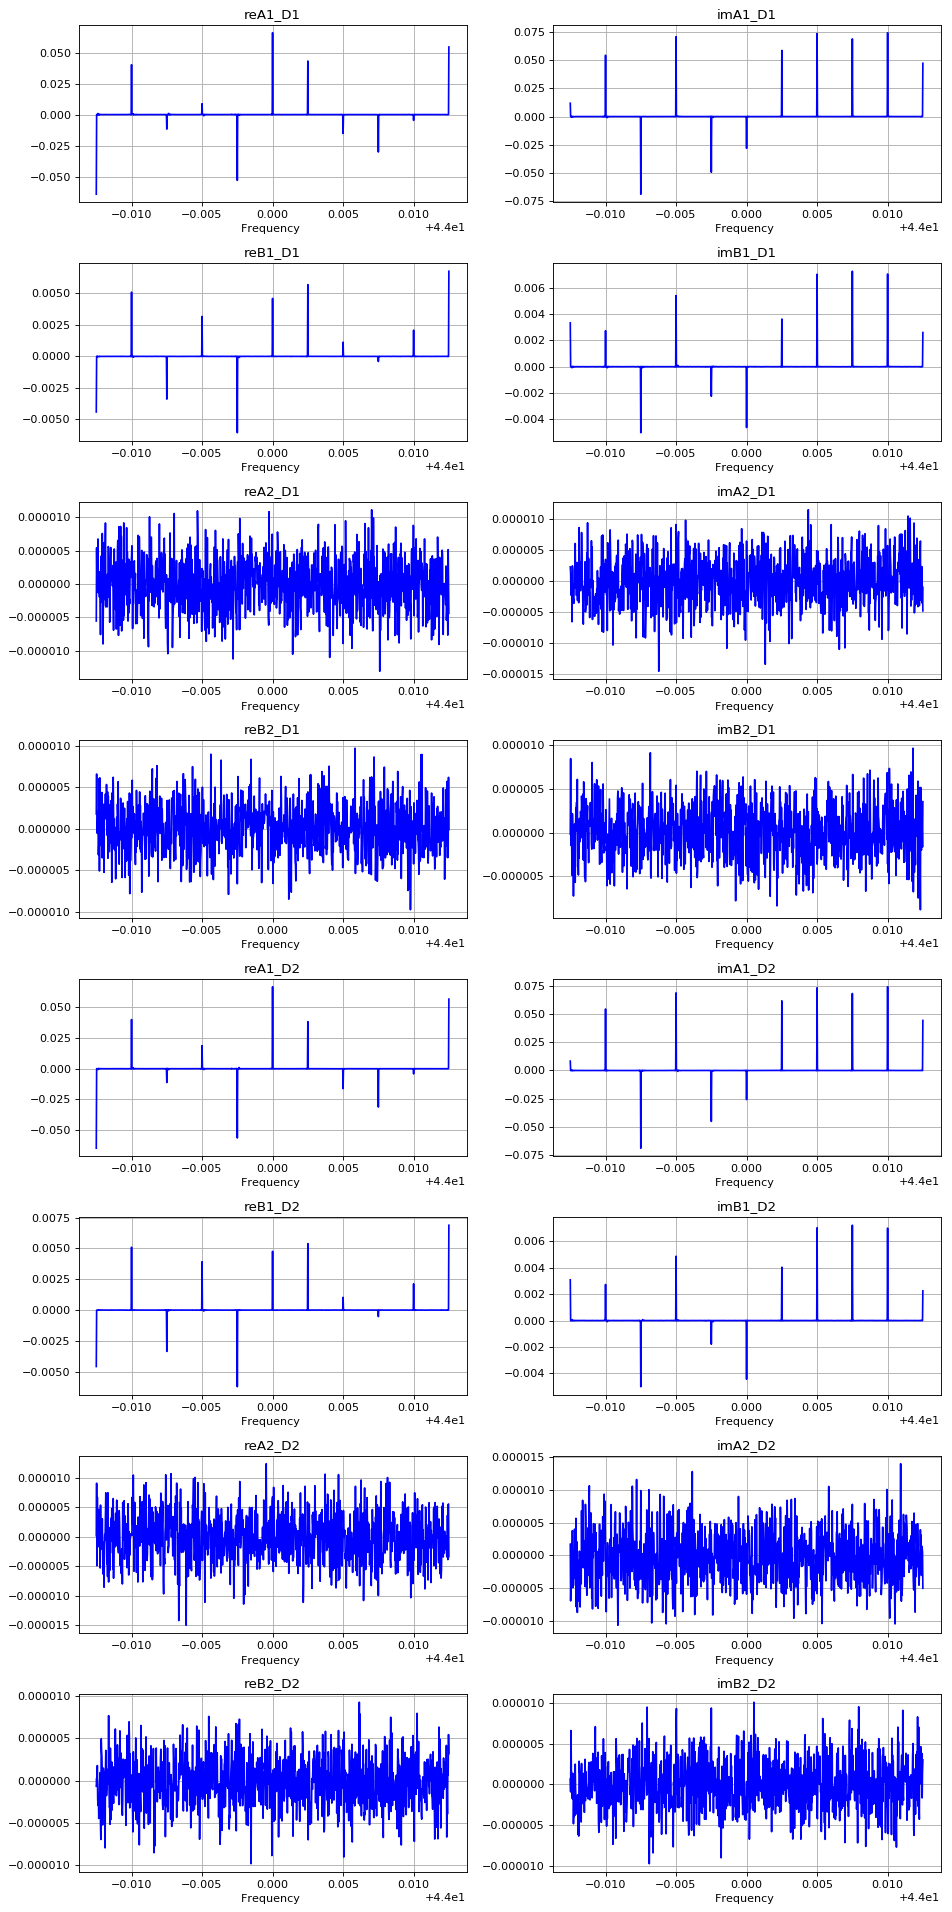

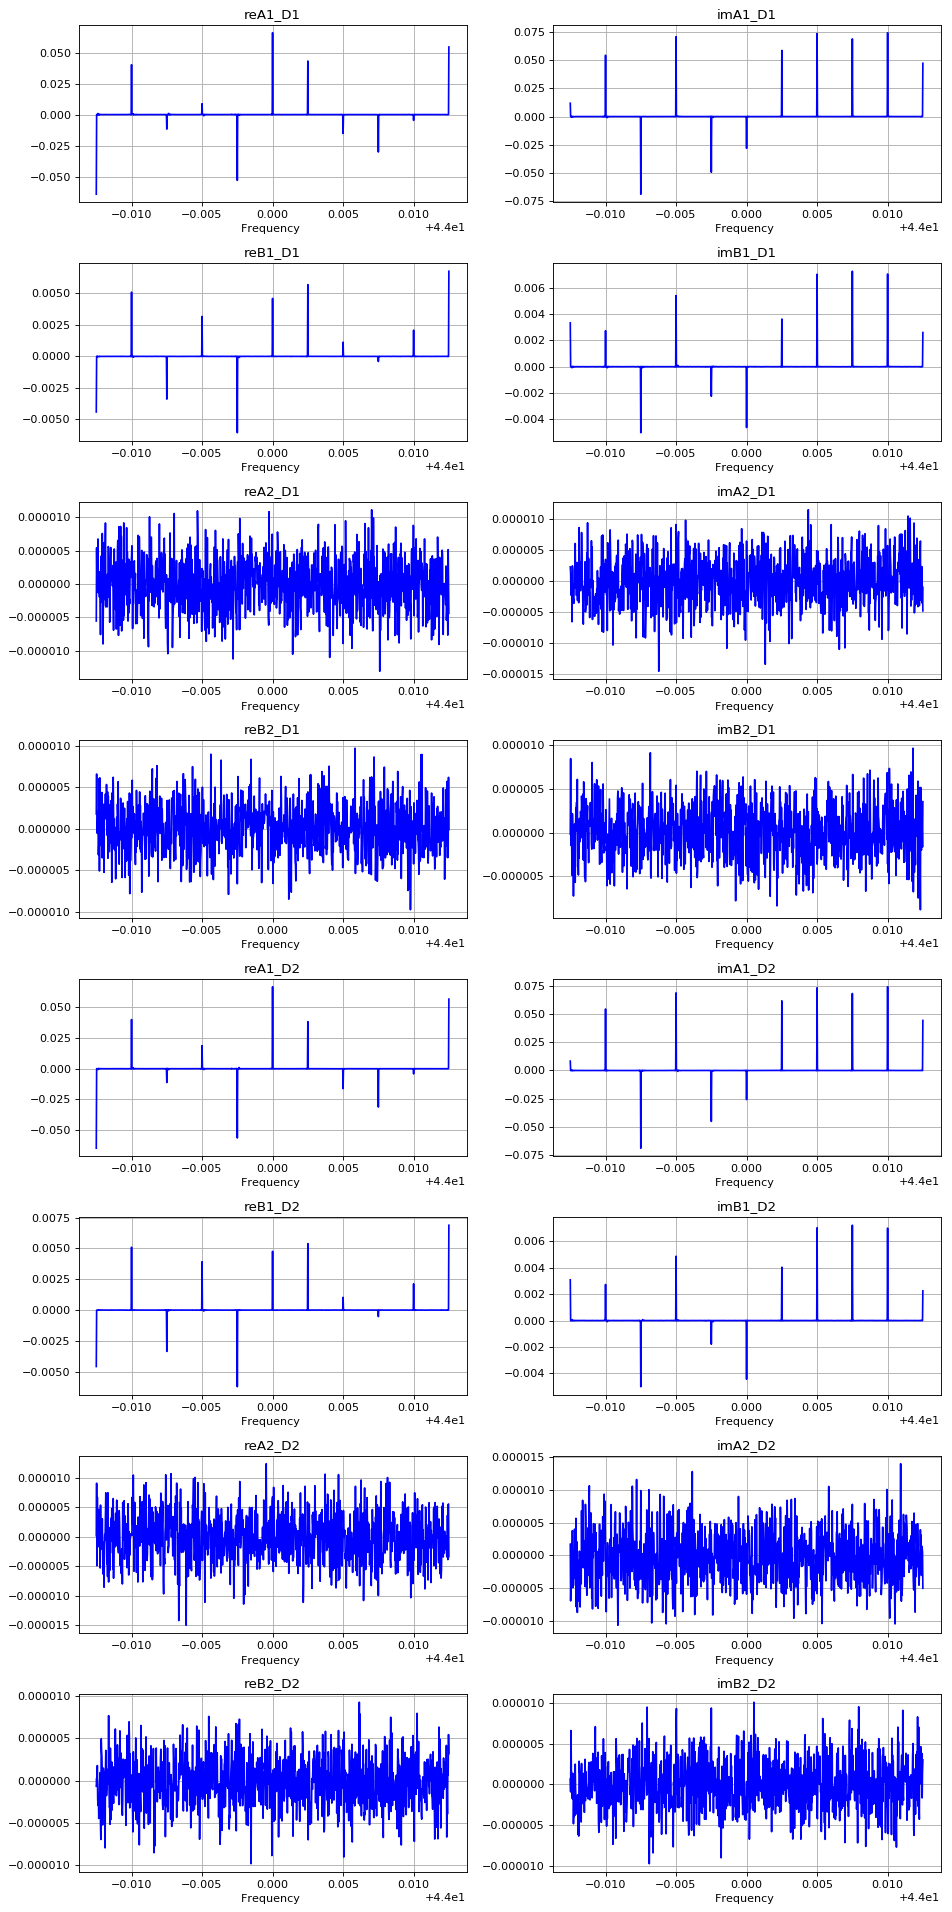

In [107]:
test_w2p.show()

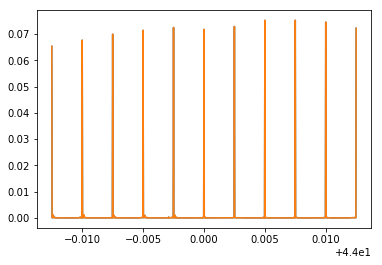

In [114]:
plt.plot(test_w2p["Frequency"],test_w2p.get_amplitude("A1_D1"))
plt.show()

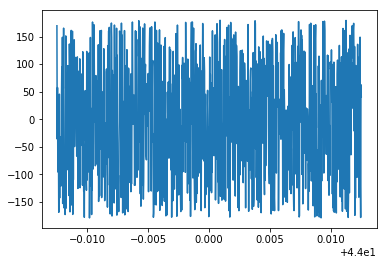

In [117]:
plt.plot(test_w2p["Frequency"],test_w2p.get_phase("A1_D1"))
plt.show()

In [116]:
print test_w2p.comments

[['Freq(GHz) a1_1 b1_1 a2_1 b2_1 a1_2 b1_2 a2_2 b2_2   (real/imaginary)', 0, 0]]


In [119]:
test_w2p.header=["A Test of adding a header"]

In [120]:
print(test_w2p)

!A Test of adding a header
!Frequency,reA1_D1,imA1_D1,reB1_D1,imB1_D1,reA2_D1,imA2_D1,reB2_D1,imB2_D1,reA1_D2,imA1_D2,reB1_D2,imB1_D2,reA2_D2,imA2_D2,reB2_D2,imB2_D2
43.9875	-0.0642283646414	0.011837822104	-0.00441356625652	0.0033224885083	-5.56049311937e-06	2.25867641541e-06	1.79288926458e-06	-1.80973471103e-07	-0.0649190647853	0.00835648985524	-0.00458217736491	0.00308674174214	1.97753262212e-07	1.70455353705e-06	-6.79185384788e-07	6.70111202097e-07
43.987525	6.88062588073e-05	-4.97143673573e-05	-1.16835173194e-06	-9.41553122185e-06	5.40977018789e-06	1.26150281486e-06	6.62159847689e-06	8.47639792505e-06	5.89948518276e-05	-4.94891623497e-05	-1.15508534446e-05	-1.13309338271e-05	9.09344255699e-06	-6.89632698004e-06	2.5518954037e-07	-9.09032438861e-07
43.98755	7.45390872631e-05	0.000116590153025	1.61226037887e-05	-2.03273093657e-07	-3.03339961261e-07	-2.30520745689e-06	-4.40506295563e-08	-1.46281795997e-06	5.16573063562e-05	8.5912996939e-05	-4.79202611519e-06	-1.16445510621e-05	-4.88743

In [121]:
test_w2p.save_schema(change_extension(test_w2p.path,"schema"))

In [122]:
schema_2=read_schema(change_extension(test_w2p.path,"schema"))

In [123]:
schema_2

{'block_comment_begin': None,
 'block_comment_end': None,
 'column_descriptions': None,
 'column_names': None,
 'column_names_begin_line': 1,
 'column_names_begin_token': '!',
 'column_names_delimiter': ',',
 'column_names_end_line': 2,
 'column_names_end_token': '\n',
 'column_types': ['float',
  'float',
  'float',
  'float',
  'float',
  'float',
  'float',
  'float',
  'float',
  'float',
  'float',
  'float',
  'float',
  'float',
  'float',
  'float',
  'float'],
 'column_units': ['GHz',
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None],
 'comment_begin': '!',
 'comment_end': '\n',
 'comments': [['Freq(GHz) a1_1 b1_1 a2_1 b2_1 a1_2 b1_2 a2_2 b2_2   (real/imaginary)',
   0,
   0]],
 'data': None,
 'data_begin_line': 2,
 'data_begin_token': None,
 'data_delimiter': '\t',
 'data_end_line': None,
 'data_end_token': None,
 'data_list_dictionary': None,
 'data_table_element_separator': None,
 'directory': Non

In [125]:
test_w2p.save('C:\\Users\\sandersa\\PyCharmProjects\\Jupyter-Notebooks\\W2p_Example_Files\\adt_meas_nameLoadAttached.w2p')

In [124]:
test_w2p.path

'C:\\Users\\sandersa\\PyCharmProjects\\Jupyter-Notebooks\\W2p_Example_Files\\meas_nameLoadAttached.w2p'

In [126]:
w2p_2=W2P('C:\\Users\\sandersa\\PyCharmProjects\\Jupyter-Notebooks\\W2p_Example_Files\\adt_meas_nameLoadAttached.w2p',**schema_2)

Warning \n is in the remove tokens


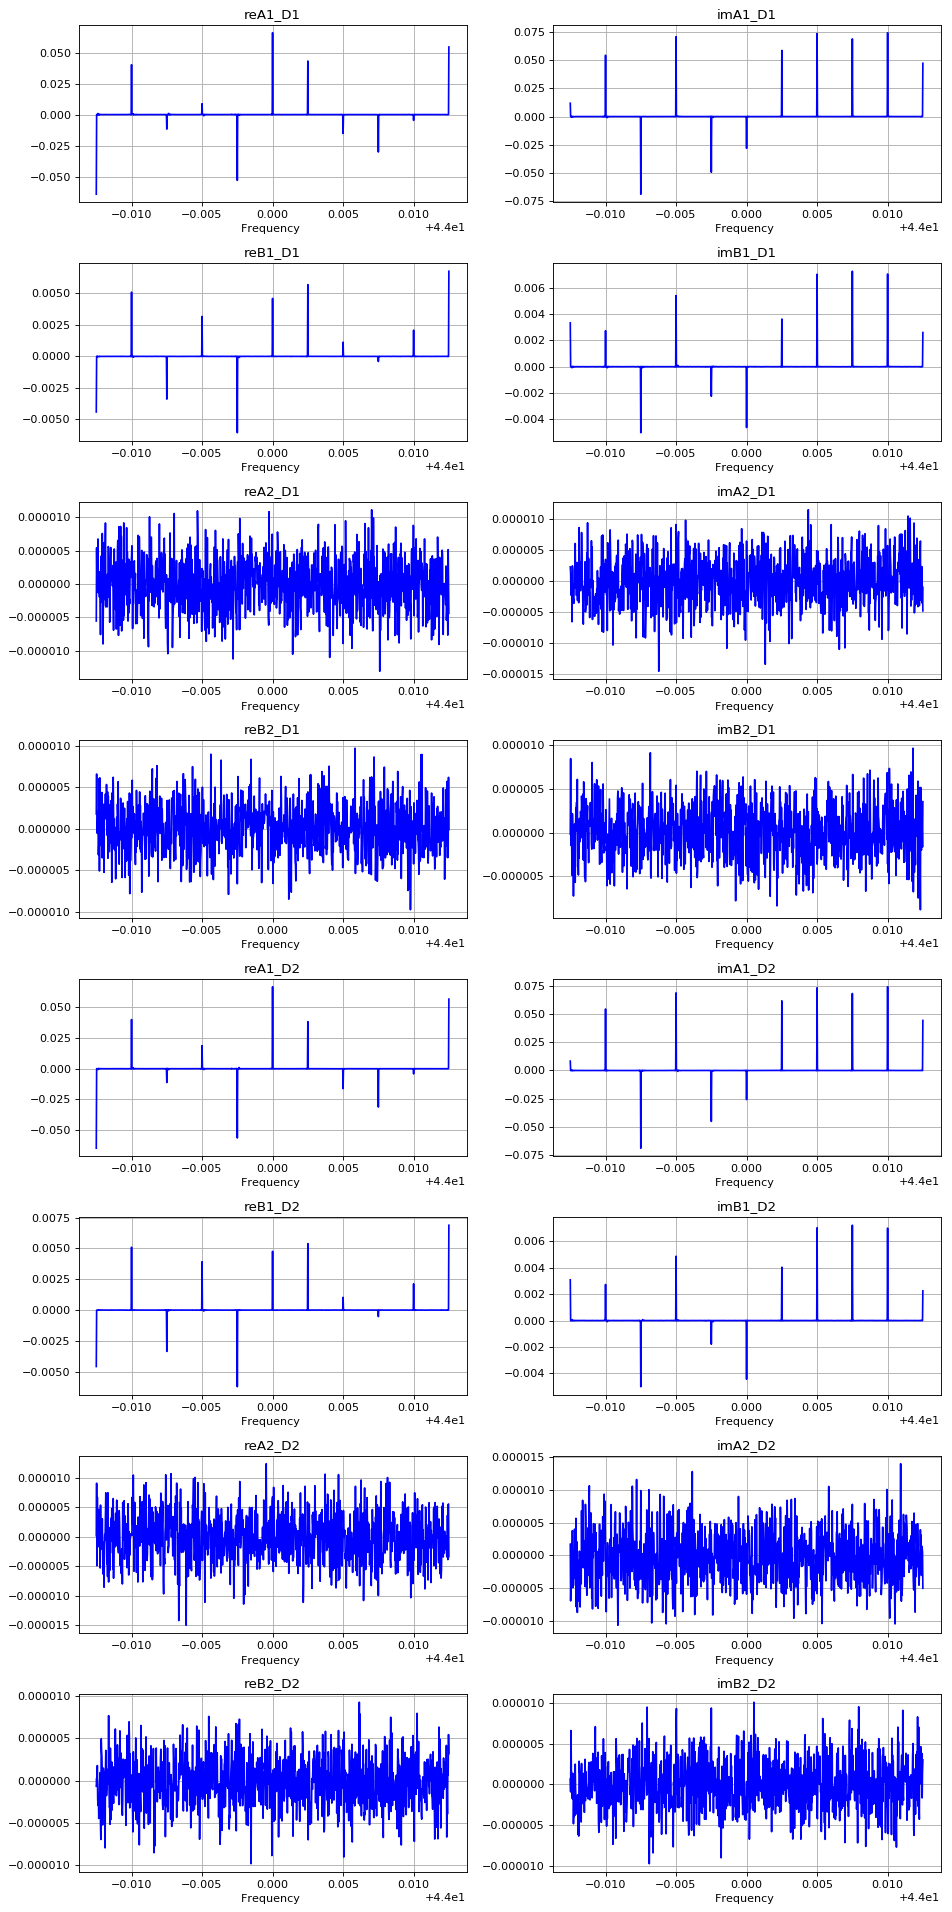

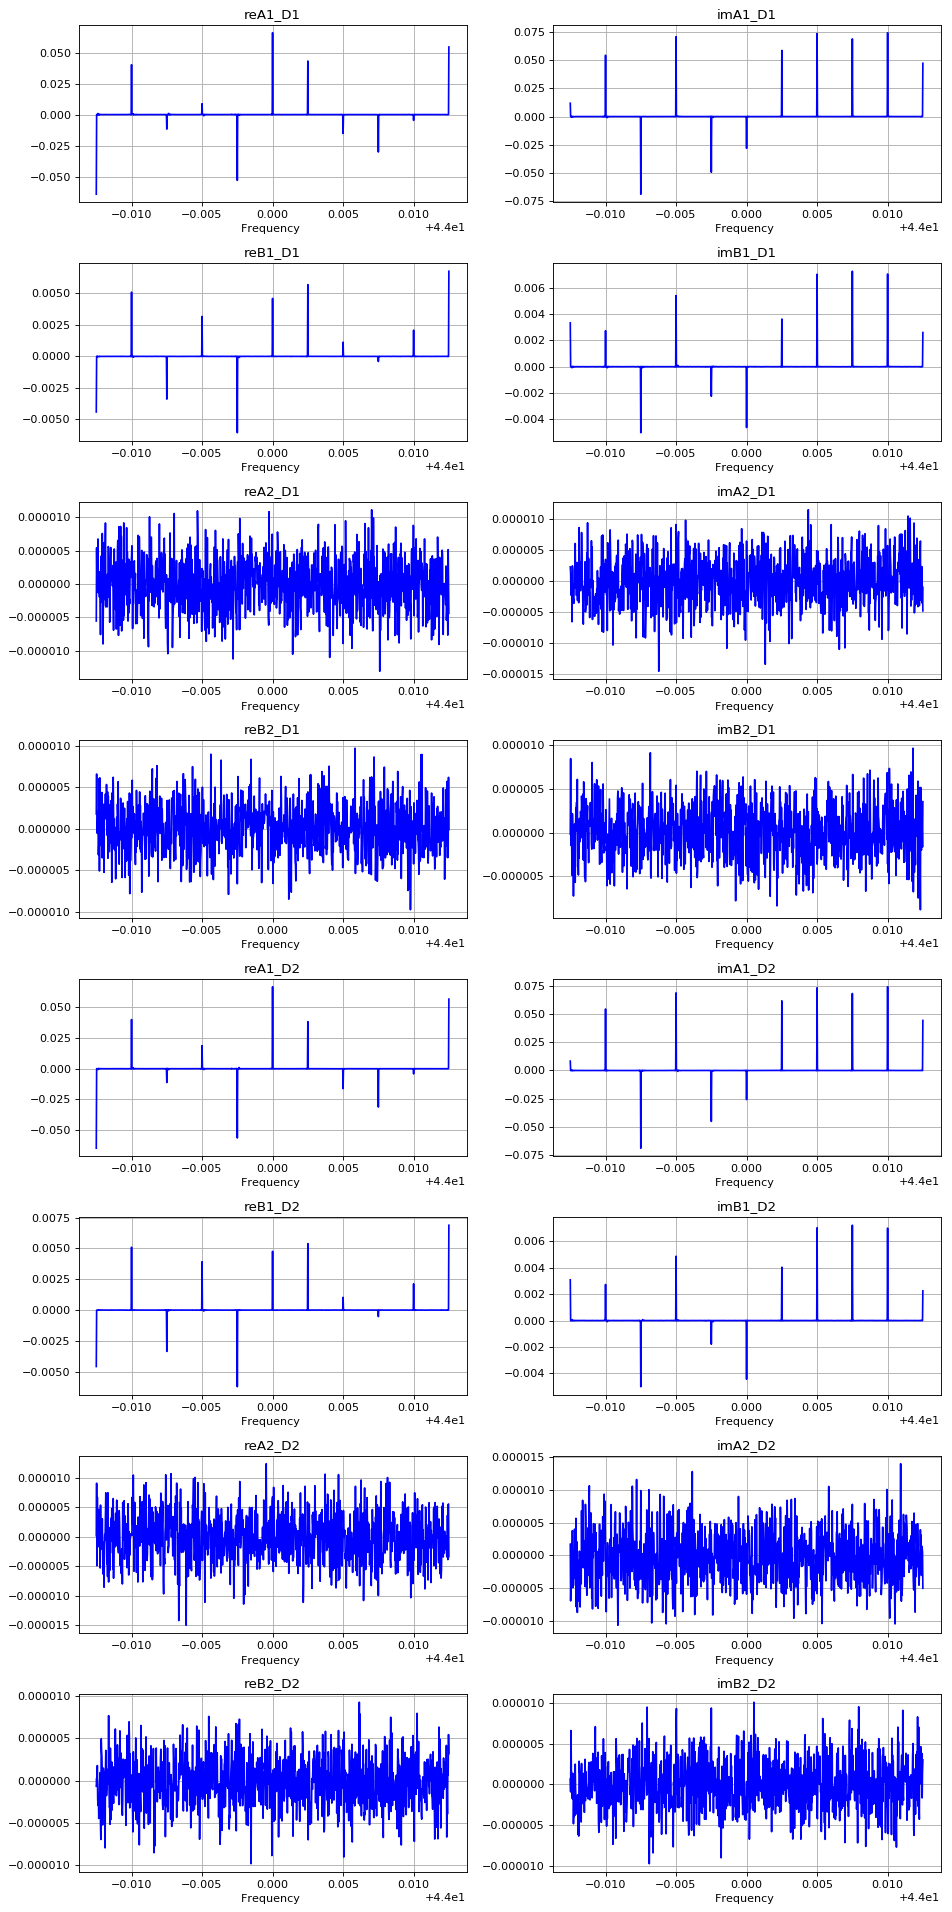

In [127]:
w2p_2.show()

In [128]:
w2p_2.header

['A Test of adding a header']

In [129]:
w2p_2.options

{'block_comment_begin': None,
 'block_comment_end': None,
 'column_descriptions': None,
 'column_names': None,
 'column_names_begin_line': 1,
 'column_names_begin_token': '!',
 'column_names_delimiter': ',',
 'column_names_end_line': 2,
 'column_names_end_token': '\n',
 'column_types': ['float',
  'float',
  'float',
  'float',
  'float',
  'float',
  'float',
  'float',
  'float',
  'float',
  'float',
  'float',
  'float',
  'float',
  'float',
  'float',
  'float'],
 'column_units': ['GHz',
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None],
 'comment_begin': '!',
 'comment_end': '\n',
 'comments': [['Freq(GHz) a1_1 b1_1 a2_1 b2_1 a1_2 b1_2 a2_2 b2_2   (real/imaginary)',
   0,
   0]],
 'data': None,
 'data_begin_line': 2,
 'data_begin_token': None,
 'data_delimiter': '\t',
 'data_end_line': None,
 'data_end_token': None,
 'data_list_dictionary': None,
 'data_table_element_separator': None,
 'directory': Non

In [130]:
print(w2p_2)

!A Test of adding a header
!Frequency,reA1_D1,imA1_D1,reB1_D1,imB1_D1,reA2_D1,imA2_D1,reB2_D1,imB2_D1,reA1_D2,imA1_D2,reB1_D2,imB1_D2,reA2_D2,imA2_D2,reB2_D2,imB2_D2
43.9875	-0.0642283646414	0.011837822104	-0.00441356625652	0.0033224885083	-5.56049311937e-06	2.25867641541e-06	1.79288926458e-06	-1.80973471103e-07	-0.0649190647853	0.00835648985524	-0.00458217736491	0.00308674174214	1.97753262212e-07	1.70455353705e-06	-6.79185384788e-07	6.70111202097e-07
43.987525	6.88062588073e-05	-4.97143673573e-05	-1.16835173194e-06	-9.41553122185e-06	5.40977018789e-06	1.26150281486e-06	6.62159847689e-06	8.47639792505e-06	5.89948518276e-05	-4.94891623497e-05	-1.15508534446e-05	-1.13309338271e-05	9.09344255699e-06	-6.89632698004e-06	2.5518954037e-07	-9.09032438861e-07
43.98755	7.45390872631e-05	0.000116590153025	1.61226037887e-05	-2.03273093657e-07	-3.03339961261e-07	-2.30520745689e-06	-4.40506295563e-08	-1.46281795997e-06	5.16573063562e-05	8.5912996939e-05	-4.79202611519e-06	-1.16445510621e-05	-4.88743

In [ ]:
        figure, axes = plt.subplots(ncols=number_columns, nrows=number_rows, sharex=plot_options["share_x"],
                                    figsize=plot_options["plot_size"], dpi=plot_options["dpi"])

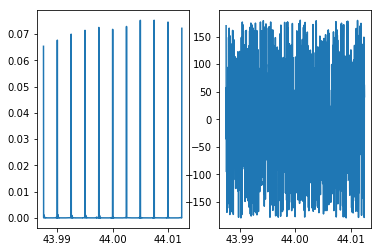

In [132]:
figure,axes=plt.subplots(ncols=2,nrows=1)
axes[0].plot(test_w2p["Frequency"],test_w2p.get_amplitude("A1_D1"))
axes[1].plot(test_w2p["Frequency"],test_w2p.get_phase("A1_D1"))
plt.show()

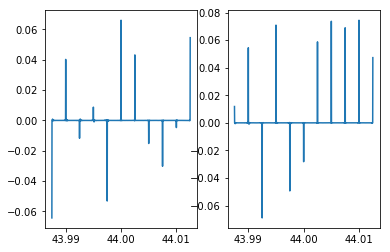

In [134]:
figure,axes=plt.subplots(ncols=2,nrows=1)
axes[0].plot(test_w2p["Frequency"],test_w2p["reA1_D1"])
axes[1].plot(test_w2p["Frequency"],test_w2p["imA1_D1"])
plt.show()

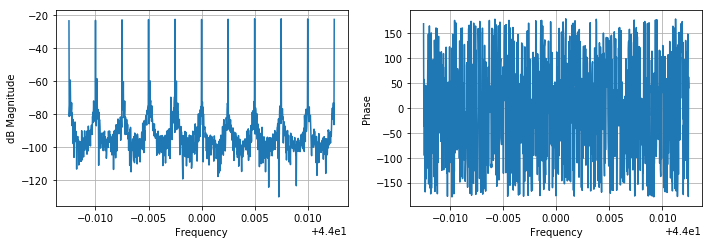

In [153]:
figure,axes=plt.subplots(ncols=2,nrows=1,figsize=(10,3.5))
axes[0].plot(test_w2p["Frequency"],20*np.log10(np.array(test_w2p.get_amplitude("A1_D1"))))
axes[0].grid()
axes[0].set_xlabel("Frequency")
axes[0].set_ylabel("dB Magnitude")

axes[1].plot(test_w2p["Frequency"],test_w2p.get_phase("A1_D1"))
axes[1].grid()
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("Phase")
figure.tight_layout()
plt.show()

In [138]:
np.log(10)

2.3025850929940459

In [154]:
import numpy as np

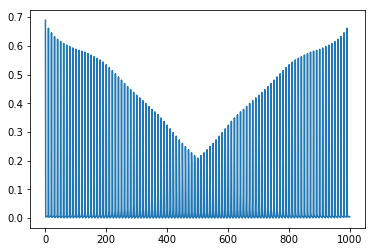

In [187]:
amp_fft=np.fft.fft(np.array(test_w2p.get_amplitude("A1_D1")))
amp_fft_conjugate=np.conjugate(amp_fft)
power_spectrum=np.abs(amp_fft*amp_fft_conjugate)
plt.plot(power_spectrum)
plt.show()

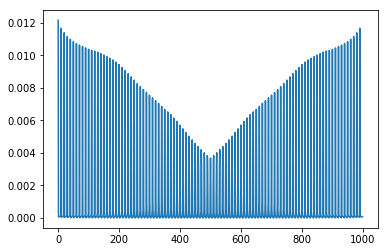

In [188]:
pdf_spectrum=power_spectrum/np.sum(power_spectrum)
plt.plot(pdf_spectrum)
plt.show()

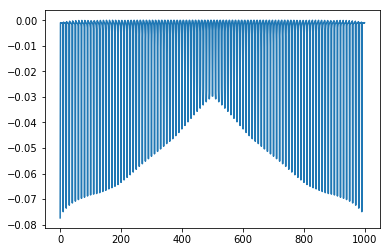

In [189]:
spectral_entropy=1*pdf_spectrum*np.log2(pdf_spectrum)
plt.plot(spectral_entropy)
plt.show()

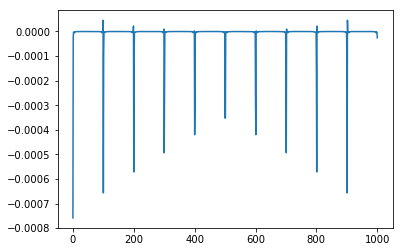

In [191]:
spectral_entropy=np.fft.ifft(pdf_spectrum*np.log2(pdf_spectrum)/np.log2(len(pdf_spectrum)))
plt.plot(spectral_entropy)
plt.show()

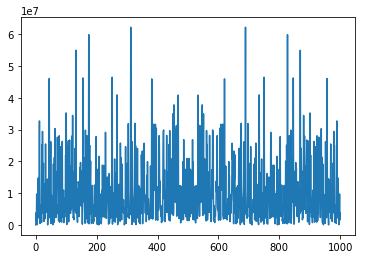

In [192]:
amp_fft=np.fft.fft(np.array(test_w2p.get_phase("A1_D1")))
amp_fft_conjugate=np.conjugate(amp_fft)
power_spectrum=abs(amp_fft*amp_fft_conjugate)

plt.plot(power_spectrum)
plt.show()

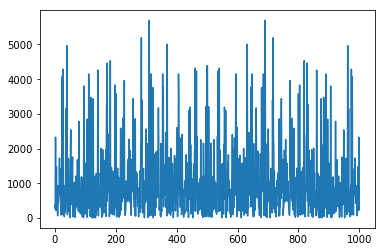

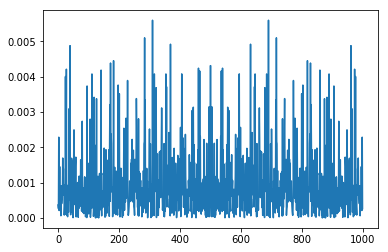

In [179]:
amp_fft=np.fft.fft(np.array(np.random.normal(size=[len(test_w2p["Frequency"])])))
amp_fft_conjugate=np.conjugate(amp_fft)
power_spectrum=np.abs(amp_fft*amp_fft_conjugate)
plt.plot(power_spectrum)
plt.show()
pdf_spectrum=power_spectrum/np.sum(power_spectrum)
plt.plot(pdf_spectrum)
plt.show()

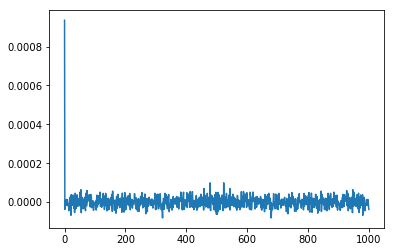

In [184]:
spectral_entropy=-1*np.fft.ifft(pdf_spectrum*np.log2(pdf_spectrum))/np.log2(len(pdf_spectrum))
plt.plot(spectral_entropy)
plt.show()

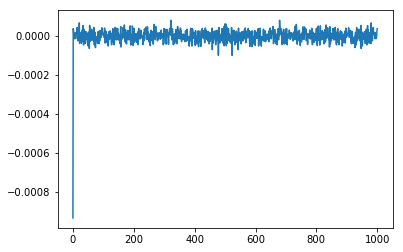

In [182]:
time_spectral_entropy=np.fft.ifft(pdf_spectrum*np.log2(pdf_spectrum))/np.log2(len(pdf_spectrum))
plt.plot(time_spectral_entropy)
plt.show()